<center><h1><b> SSCS 2025 Code-a-Chip Challenge </b></h1>
<h1> Automated design of a R2R digital-to-analog converter</h1>


| Name | IEEE Member | Affiliation |
|:---:|:---:|:---:|
| Govindarajan Aadith Yadav | Yes | National University of Singapore |
| An Wei Teck | Yes | National University of Singapore |

</center>

This notebook implements a 4-bit R2R digital-to-analog (DAC) converter that creates a custom chip from user input. Users can choose to input various parameters (eg. common-mode input voltage range) and this notebook will automatically generate a netlist based off the user input and output a GDS file based off the netlist.

The R2R DAC's design is based off the following schematic:

![image](schematic.png)


This notebook takes in user inputs, calculates the width/length ratios of the MOSFET's within the op-amp, and generates a netlist using PySpice. This netlist is then parsed into ALIGN, which automates the layout and outputs a GDS file of the design.

# Install the necessary dependencies
## 1. Install PySpice
[PySpice](https://pyspice.fabrice-salvaire.fr/releases/v1.4/overview.html) is an open source Python module which provides a Python interface to generating a SPICE netlist.

In [31]:
!pip install PySpice

## 2. Install PDK
The [SKY130 PDK](https://skywater-pdk.readthedocs.io/en/main/) is an open-source PDK for a 130nm CMOS technology developed by SkyWater Technology. It will serve as the basis for all the device models used in this design. It is well-documented, widely-used, and suitable for a fully analog design.

In [3]:
!git clone https://github.com/ALIGN-analoglayout/ALIGN-pdk-sky130.git

Cloning into 'ALIGN-pdk-sky130'...
remote: Enumerating objects: 338, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 338 (delta 57), reused 67 (delta 28), pack-reused 210 (from 1)
Receiving objects: 100% (338/338), 129.18 KiB | 1.66 MiB/s, done.
Resolving deltas: 100% (189/189), done.


## 3. Install ALIGN
[Analog Layout, Intelligently Generated from Netlists (ALIGN)](https://align-analoglayout.github.io/ALIGN-public/) is an open source automatic layout generator analog circuits. ALIGN automatically translates a SPICE netlist of an analog circuit into a GDSII layout. It is well-documented, comes with its own examples, and most importantly, easy to use.

In [7]:
!git clone https://github.com/ALIGN-analoglayout/ALIGN-public

Cloning into 'ALIGN-public'...
remote: Enumerating objects: 54537, done.
remote: Counting objects: 100% (1010/1010), done.
remote: Compressing objects: 100% (413/413), done.
remote: Total 54537 (delta 834), reused 598 (delta 597), pack-reused 53527 (from 4)
Receiving objects: 100% (54537/54537), 330.52 MiB | 2.17 MiB/s, done.
Resolving deltas: 100% (40548/40548), done.
Updating files: 100% (2445/2445), done.


In [27]:
%cd ALIGN-public
!python3 -m venv general

/mnt/d/code-a-chip/ALIGN-public


In [6]:
!source ALIGN-public/general/bin/activate

### Install correct version of dependencies of ALIGN from existing [wheels](wheel/)

In [7]:
!pip install wheel/*.whl

Processing ./wheel/MarkupSafe-3.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./wheel/PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./wheel/align-0.9.8-cp312-cp312-linux_x86_64.whl
Processing ./wheel/blinker-1.9.0-py3-none-any.whl
Processing ./wheel/certifi-2025.6.15-py3-none-any.whl
Processing ./wheel/cffi-1.15.0-cp312-cp312-linux_x86_64.whl
Processing ./wheel/charset_normalizer-3.4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./wheel/click-8.2.1-py3-none-any.whl
Processing ./wheel/colorlog-6.9.0-py3-none-any.whl
Processing ./wheel/dash-3.1.1-py3-none-any.whl
Processing ./wheel/flask-3.1.1-py3-none-any.whl
Processing ./wheel/flatdict-4.0.1-py3-none-any.whl
Processing ./wheel/gdspy-1.6.13-cp312-cp312-linux_x86_64.whl
Processing ./wheel/idna-3.10-py3-none-any.whl
Processing ./wheel/importlib_metadata-8.7.0-py3-none-any.whl
Processing ./wheel/itsdangerous-2.2.0-py3-none-any.whl
Processing ./wheel/

In [30]:
!pip install -e .[test]

Obtaining file:///mnt/d/code-a-chip/ALIGN-public
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
Checking if build backend supports build_editable ... done
  Building editable for align (pyproject.toml) ... done
  Created wheel for align: filename=align-0.9.8-0.editable-py3-none-any.whl size=19939 sha256=31b28b29b0aa62defea30b91313d1500e036bb4eb239405e3a8f11a512a012a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-sn6hc0zl/wheels/a6/27/7b/54d3a00c146626931543b97fdadc6a0d5b59d9bfa19ed75808
Successfully built align
  Attempting uninstall: align
    Found existing installation: align 0.9.8
    Uninstalling align-0.9.8:
      Successfully uninstalled align-0.9.8


In [8]:
!schematic2layout.py -h

usage: schematic2layout.py [-h] -p PDK_DIR [-w WORKING_DIR] [-f NETLIST_FILE]
                           [-s SUBCKT] [-flat FLATTEN] [-n NVARIANTS]
                           [-e EFFORT] [-x]
                           [-l {DEBUG,INFO,WARNING,ERROR,CRITICAL}]
                           [-v {DEBUG,INFO,WARNING,ERROR,CRITICAL}] [-r] [-u]
                           [-pdn] [--version] [--flow_start FLOW_START]
                           [--flow_stop FLOW_STOP]
                           [--router_mode {top_down,bottom_up,collect_pins,no_op}]
                           [--router {astar,hanan}] [--gui] [--port PORT]
                           [--skipGDS] [--lambda_coeff LAMBDA_COEFF]
                           [--nroutings NROUTINGS] [--viewer]
                           [--select_in_ILP] [--place_using_ILP]
                           [--use_analytical_placer]
                           [--placer_sa_iterations PLACER_SA_ITERATIONS]
                           [--seed SEED] [--ilp_solver {symp

# R2R DAC Converter
Below is the actual code required to generate the netlist and GDSII file of the R2R DAC converter

The op-amp in the R2R DAC converter is a simple 2-stage CMOS op-amp with Miller compensation and a PMOS input. PMOS input was chosen to give it a much lower input-common mode range so it would be able to work with the low voltages from the R2R ladder. This op-amp is based off the following schematic:

<center>

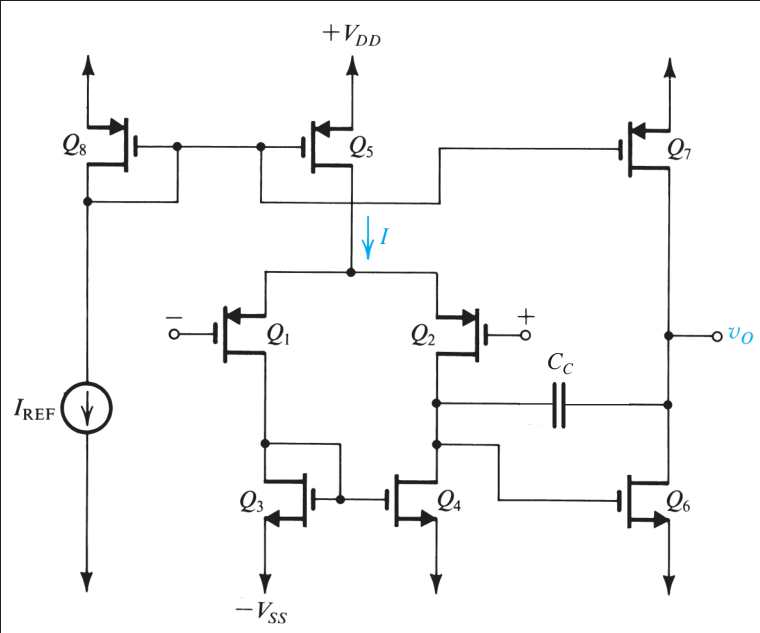

</center>

## Op Amp calculations

User is required to give the following inputs:
* `c_load`: load capacitance in pF
* `gbw`: gain bandwidth in MHz
* `sr`: slew rate in V/us
* `icmr_max`: maximum input common mode range
* `icmr_min`: minimum input common mode range
* `vdd`: maxmimum voltage supply range
* `vss`: minimum voltage supply range

\
The following parameters are not user inputs, but parameters obtained from the SkyWater's 130nm process
* `unCox`: nmos parameter, unitless, in micro
* `upCox`: pmos parameter, unitless, in micro
* `vtn_min`: NMOS min threshold voltage
* `vtn_max`: NMOS max threshold voltage
* `vtp_max`: PMOS max threshold voltage

\
The following code then takes these parameters, does the necessary calculations for the width/length ratios of each MOSFFET in the op-amp, and outputs a dictionary containing all the parameters necessary for generating the netlist

In [2]:
# @title
import math
from PySpice.Unit import *

#-------------------------------------------------------USER PARAMETERS-------------------------------------------------------
round_to_factor = 0.2
c_load = 2 #load capacitance in pF
gbw = 5 #gain bandwidth in MHz
sr = 10 #slew rate in V/us
unCox = 240 #nmos parameter, unitless, in micro
upCox = 70 #pmos parameter, unitless, in micro
vtn_min = 0.6 #NMOS min threshold voltage
vtn_max = 0.62 #NMOS max threshold voltage
vtp_max = 0.65 #PMOS max threshold voltage
icmr_min = -0.2 #minimum input common mode range
icmr_max = 1 #max input common mode range
vdd = 1.8
vss = -1.8



def round_to(value, round_to, up):
  if up:
    value = math.ceil(value/round_to)*round_to
  else:
    value = math.floor(value/round_to)*round_to
  return round(value, 1)

#-------------------------------------------------------CAlCULATING PARAMETERS-------------------------------------------------------

design_params = {}

# Load capacitance in pico
design_params['c_load'] = c_load

#Miller capacitance in pico
c_miller = 0.22 * c_load
c_miller = math.ceil(c_miller * 10) / 10
c_miller=0.8
design_params['c_miller'] = c_miller

#M1 transconductance in uS (micro Seimens)
g_m1 = ((gbw) * (c_miller) * 2 * math.pi)
design_params['g_m1'] = g_m1

# tail current in uA
i_tail = (sr) * (c_miller)
design_params['i_tail'] = i_tail

# width length ratios for M1 and M2 (differential pair)
s1s2 = ((g_m1)**2) / ((i_tail)*(upCox))
s1s2 = round_to(s1s2, round_to_factor, False)
design_params['s1s2'] = s1s2

# width length ratios for M3 M4 (active load)
max_Vo3 = icmr_min - vss - vtn_max + vtp_max
s3s4 = (i_tail) / ((unCox) * ((max_Vo3 - vtp_max)**2))
s3s4 = round_to(s3s4, round_to_factor, True)
design_params['s3s4'] = s3s4

# width length ratios for M5 M8 (current mirror)
max_Vo5 = vdd - icmr_max - vtp_max - ((g_m1/1e6) * (i_tail/1e6))
s5s8 = (i_tail) / ((upCox) * (max_Vo5**2))
s5s8 = round_to(s5s8, round_to_factor, True)
design_params['s5s8'] = s5s8

# width length ratios for M6
g_m6 = 10 * g_m1
g_m4 = math.sqrt((i_tail)*(upCox)*(s3s4))
s6 = g_m6 / g_m4 * s3s4
s6 = round_to(s6, round_to_factor, True)
design_params['s6'] = s6

# width length ratios for M7
i6 = s6 / s3s4 * (0.5*(i_tail))
s7 = i6 / i_tail * s5s8
s7 = round_to(s7, round_to_factor, True)
design_params['s7'] =s7


#-------------------------------------------------------OUTPUT-------------------------------------------------------
print(design_params)

{'c_load': 2, 'c_miller': 0.8, 'g_m1': 25.132741228718345, 'i_tail': 8.0, 's1s2': 1.0, 's3s4': 0.2, 's5s8': 5.2, 's6': 4.8, 's7': 62.4}


## Generate Netlist

Now PySpice is used to generate the netlist. It uses the following default parameters:
* `LENGTH`: the gate length of the MOSFETs, set at 2.1um
* `WIDTH`: the gate width of the MOSFETs, set at 0.42um
* `R`: the base resistance value of the resistors used in the R2R ladder

The `LENGTH` and `GATE` values are taken from certain constraints within ALIGN, however, `R` can be changed to the user's preference. ALIGN requires that the smallest value of the width or length be 0.21um, and that the number of fingers of the MOSFETs have to be an even number.

In [3]:
from PySpice.Spice.Netlist import Circuit, SubCircuit
from PySpice.Unit import *

#-------------------------------------------------------SETTINGS-------------------------------------------------------
#default gate length and width
LENGTH=nano(2100)
WIDTH=nano(420)

#default resistance value in Ohms
R=kilo(1)


#-------------------------------------------------------OPAMP-------------------------------------------------------

#sky130 model names
PMOS_MODEL='sky130_fd_pr__pfet_01v8'
NMOS_MODEL='sky130_fd_pr__nfet_01v8'


def round_to_even(value):
  #nf must be even number
  value = round(value)
  return math.ceil(value / 2) * 2


class OpAmp(SubCircuit):
    def __init__(self, name, Vplus, Vminus, Vss, Vdd, Vout, Ibias, design_params:list):
        SubCircuit.__init__(self, name, Vplus, Vminus, Vss, Vdd, Vout, Ibias)

        #capacitors
        self.C('1', 'net3', 'Vout', pico(design_params['c_miller']))
        #ALIGN cant work with capacitors > 1pF, this capacitor will be externally connected
        # self.C('2', 'VSS', 'Vout', pico(design_params['c_load']), m=1)

        # Xschem order is drain gate source body
        # self.X order is body drain gate source

        #differential pair
        nf = round_to_even(design_params['s1s2']*LENGTH/WIDTH)
        self.X('M1', PMOS_MODEL, 'net2', Vminus, 'net1', 'net1', L=LENGTH, W=WIDTH, nf=nf, m=1)
        self.X('M2', PMOS_MODEL, 'net3', Vplus, 'net1', 'net1', L=LENGTH, W=WIDTH, nf=nf, m=1)

        # #active load
        nf = round_to_even(design_params['s3s4']*LENGTH/WIDTH)
        self.X('M3', NMOS_MODEL, 'net2', 'net2', Vss, Vss, L=LENGTH, W=WIDTH, nf=nf, m=1)
        self.X('M4', NMOS_MODEL, 'net3', 'net2', Vss, Vss, L=LENGTH, W=WIDTH, nf=nf, m=1)

        # #current mirror
        nf = round_to_even(design_params['s5s8']*LENGTH/WIDTH)
        self.X('M5', PMOS_MODEL, 'net1', Ibias, Vdd, Vdd, L=LENGTH, W=WIDTH, nf=nf, m=1)
        self.X('M8', PMOS_MODEL, Ibias, Ibias, Vdd, Vdd, L=LENGTH, W=WIDTH, nf=nf, m=1)

        # #amplifier stage
        nf = round_to_even(design_params['s6']*LENGTH/WIDTH)
        self.X('M6', PMOS_MODEL, Vout, 'net3', Vss, Vss, L=LENGTH, W=WIDTH, nf=nf, m=1)
        nf = round_to_even(design_params['s7']*LENGTH/WIDTH)
        self.X('M7', PMOS_MODEL, Vout, Ibias, Vdd, Vdd, L=LENGTH, W=WIDTH, nf=nf, m=1)

#-------------------------------------------------------R2R DAC-------------------------------------------------------
class R2RDAC(SubCircuit):
    def __init__(self, name, R, GND, VSS, VDD, VOUT, IBIAS):
      SubCircuit.__init__(self, name, GND, VSS, VDD, VOUT, IBIAS)
      self.X('1', 'OpAmp', 'GND', 'net4', 'VSS', 'VDD', 'Vout', 'Ibias')

      self.R('1', 'net12', 'net4', R)
      self.R('2', 'net13', 'net12', R)
      self.R('3', 'net3', 'net4', R)
      self.R('4', 'net10', 'net3', R)
      self.R('5', 'net11', 'net10', R)
      self.R('6', 'net2', 'net3', R)
      self.R('7', 'net9', 'net2', R)
      self.R('8', 'net8', 'net9', R)
      self.R('9', 'net1', 'net2', R)
      self.R('10', 'net6', 'net1', R)
      self.R('11', 'net7', 'net6', R)
      self.R('12', 'net5', 'net1', R)
      self.R('13', 'GND', 'net5', R)
      self.R('14', 'Vout', 'net4', R)


circuit = Circuit('R2R-DAC')
circuit.subcircuit(OpAmp('OpAmp', 'V+', 'V-', 'VSS', 'VDD', 'Vout', 'Ibias', design_params))
circuit.subcircuit(R2RDAC('R2RDAC', R, 'GND', 'VSS', 'VDD', 'Vout', 'Ibias'))
circuit.X('DAC1', 'R2RDAC', 'GND', 'VSS', 'VDD', 'Vout', 'Ibias')

#-------------------------------------------------------Output-------------------------------------------------------
# Write to file for ALIGN
with open('./R2RDAC.sp', 'w') as f:
    f.write(str(circuit))
    f.write('.end\n')
    print("R2R-DAC.spice written to ./R2RDAC.sp\n")

print(circuit)


R2R-DAC.spice written to ./R2RDAC.sp

.title R2R-DAC
.subckt OpAmp V+ V- VSS VDD Vout Ibias
C1 net3 Vout 0.8p
XM1 net2 V- net1 net1 sky130_fd_pr__pfet_01v8 L=2100n W=420n m=1 nf=6
XM2 net3 V+ net1 net1 sky130_fd_pr__pfet_01v8 L=2100n W=420n m=1 nf=6
XM3 net2 net2 VSS VSS sky130_fd_pr__nfet_01v8 L=2100n W=420n m=1 nf=2
XM4 net3 net2 VSS VSS sky130_fd_pr__nfet_01v8 L=2100n W=420n m=1 nf=2
XM5 net1 Ibias VDD VDD sky130_fd_pr__pfet_01v8 L=2100n W=420n m=1 nf=26
XM8 Ibias Ibias VDD VDD sky130_fd_pr__pfet_01v8 L=2100n W=420n m=1 nf=26
XM6 Vout net3 VSS VSS sky130_fd_pr__pfet_01v8 L=2100n W=420n m=1 nf=24
XM7 Vout Ibias VDD VDD sky130_fd_pr__pfet_01v8 L=2100n W=420n m=1 nf=312
.ends OpAmp

.subckt R2RDAC GND VSS VDD Vout Ibias
X1 GND net4 VSS VDD Vout Ibias OpAmp
R1 net12 net4 1k
R2 net13 net12 1k
R3 net3 net4 1k
R4 net10 net3 1k
R5 net11 net10 1k
R6 net2 net3 1k
R7 net9 net2 1k
R8 net8 net9 1k
R9 net1 net2 1k
R10 net6 net1 1k
R11 net7 net6 1k
R12 net5 net1 1k
R13 GND net5 1k
R14 Vout net4 1k

## Patch PDK
Add missing cap for metal 1, metal 2 and metal 3 width and pitch.

In [33]:
import os

file_path = "ALIGN-pdk-sky130/SKY130_PDK/layers.json"
# The line number to start overwriting (1-indexed).
START_LINE = 399
TRUNCATE_INDEX = START_LINE - 1 

NEW_CONTENT = """{
"Layer": "Cap",
"m4Width": 450,
"m5Width": 450,
"m1Pitch": 480,
"m1Width": 150,
"m2Pitch": 480,
"m2Width": 150,
"m3Pitch": 480,
"m3Width": 150
}

]
}
"""

with open(file_path, 'r') as f:
    lines = f.readlines()

# Truncate the list of lines: keep everything BEFORE the start line
modified_lines = lines[:TRUNCATE_INDEX]

# insert a newline before the new content for clean formatting
if modified_lines and not modified_lines[-1].endswith('\n'):
     modified_lines[-1] += '\n'
     
modified_lines.append(NEW_CONTENT)

with open(file_path, 'w') as f:
    f.writelines(modified_lines)

## Generate Layout

In [19]:
!schematic2layout.py . -p ALIGN-pdk-sky130/SKY130_PDK/

align.main INFO : Reading netlist: /mnt/d/code-a-chip/R2RDAC.sp subckt=R2RDAC, flat=0
align.compiler.compiler INFO : Starting topology identification...
align.compiler.preprocess INFO : stacking ['R4', 'R5'] 2
align.compiler.preprocess INFO : stacking ['R7', 'R8'] 2
align.compiler.preprocess INFO : stacking ['R10', 'R11'] 2
align.compiler.preprocess INFO : stacking ['R1', 'R2'] 2
align.compiler.preprocess INFO : stacking ['R12', 'R13'] 2
align.compiler.compiler INFO : Power and ground nets not found. Power grid will not be constructed.
align.compiler.compiler INFO : Completed topology identification.
align.cell_fabric.remove_duplicates ERROR : Found errors: SHORT: 0 OPEN: 2 DIFFERENT WIDTH: 0
align.cell_fabric.remove_duplicates ERROR : Found errors: SHORT: 1 OPEN: 0 DIFFERENT WIDTH: 0
align.cell_fabric.drc ERROR : Found errors: DRC 4
align.cell_fabric.remove_duplicates ERROR : Found errors: SHORT: 1 OPEN: 0 DIFFERENT WIDTH: 0
align.cell_fabric.drc ERROR : Found errors: DRC 4
align.pnr.

# Final GDSII Layout

![image](result.png)